In [10]:
import torch
import torch.nn as nn
from plotter import plots_data, plot_nn
from exact_solution import solution

In [16]:
class DiffusionPINNS(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(1,20)
        self.hidden1 = nn.Linear(20,20)
        self.hidden2 = nn.Linear(20,20)
        self.final = nn.Linear(20,1)

    def forward(self,x):
        activated1 = torch.tanh(self.input(x))
        activated2 = torch.tanh(self.hidden1(activated1))
        activated3 = torch.tanh(self.hidden2(activated2))
        output = self.final(activated3)
        return output

In [17]:
# Exact solution for data, add noise
x_full = torch.linspace(-5,5,101).view(-1,1)
y_full = solution(x_full).view(-1,1)

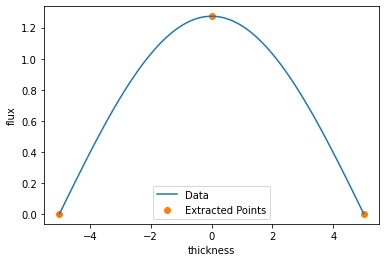

In [18]:
x_sliced = x_full[0:101:50]  # sliced into small numbers
y_sliced = y_full[0:101:50]
plots_data(x_full,y_full,x_sliced,y_sliced)  # plot real solution with sliced

In [21]:
NN = DiffusionPINNS()
learn_rate = 1e-4
epochs = 5000
plot_steps = 2000
optimizer = torch.optim.Adam(NN.parameters(),lr=learn_rate)
D, Ea = 0.9690, 0.0008
x_phy = torch.linspace(-5,5,101).unsqueeze(1)  # pass through NN
x_phy.requires_grad = True

 Epochs [2000/5000], Total Loss: 0.01506990


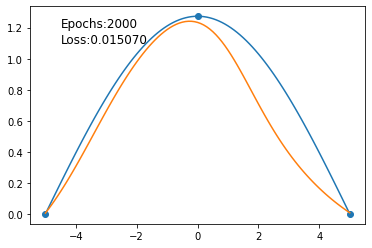

 Epochs [4000/5000], Total Loss: 0.00751104


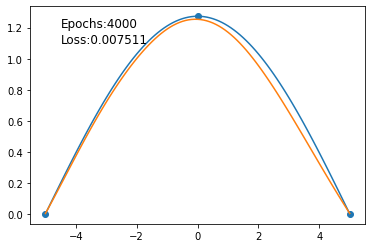

In [23]:
for i in range(epochs):
    optimizer.zero_grad()
    y_data = NN(x_sliced)
    y_pinns = NN(x_phy)
    dx = torch.autograd.grad(y_pinns.sum(),x_phy,create_graph=True)[0]
    dx2 = torch.autograd.grad(dx.sum(),x_phy,create_graph=True)[0]
    physics = D * dx2 + Ea * y_pinns
    physics_loss = torch.mean(physics**2)  # find loss form equation
    BC_loss = y_pinns[0,0]**2 + y_pinns[-1,0]**2  # find loss from BC
    data_loss = torch.mean((y_data - y_sliced) ** 2)  # find loss from purely data

    total_loss = physics_loss + data_loss + BC_loss
    total_loss.backward()
    optimizer.step()

    if (i+1) % plot_steps ==0:
        print(f' Epochs [{i+1}/{epochs}], Total Loss: {total_loss.item():.8f}')
        pinns_prediction = NN(x_phy)
        plot_nn(x_full.detach(),
                y_full.detach(),
                x_sliced.detach(),
                y_sliced.detach(),
                x_phy.detach(),
                pinns_prediction.detach(),
                i,
                total_loss.item())